In [5]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

#Importamos las librerías que vamos a usar
from pathlib import Path
import json
import pickle
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from src.models.decision_transformer import DecisionTransformer
from reference_code.dt_reference import DecisionTransformerReference
from src.models.baselines import PopularityRecommender

from scripts.evaluation import evaluate_model_batched, evaluate_popularity


# Reproducibilidad
torch.manual_seed(42)
np.random.seed(42)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Rutas
test_path = "../data/test_users/netflix8_test.json"

final_model_path = "../results/trained_models/trained_model_refactored.pt"
reference_model_path = "../results/trained_models/trained_model_reference.pt"

# Cargar usuarios de test
with open(test_path, "r") as f:
    test_users = json.load(f)


In [7]:
num_items = 752
num_groups = 8
hidden_dim = 512
n_layers = 2
n_heads = 4
context_length = 25
max_timesteps = 200
dropout = 0.1
batch_size = 64
num_epochs = 2000
learning_rate = 0.0001

# Initialize model
final_model = DecisionTransformer(
    num_groups=8,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    n_heads=n_heads,
    context_length=context_length,
    max_timestep=max_timesteps,
    dropout=dropout
).to('cuda')

# Cargar pesos entrenados
ckpt_path = Path(final_model_path)  # ajustá ruta si está en otra carpeta
state_dict = torch.load(ckpt_path, map_location=DEVICE)
final_model.load_state_dict(state_dict)  # ahora debería decir: <All keys matched successfully>

# Preparar para inferencia
final_model.to(DEVICE)
final_model.eval()

print("Modelo cargado desde:", ckpt_path)

final_model_metrics = evaluate_model_batched(
    model=final_model,
    test_data=test_users,
    device=DEVICE,
    target_return=None,
    k_list=(5, 10, 20),
    context_len=25,
    eval_batch_size=256,
)

Modelo cargado desde: ../results/trained_models/trained_model_refactored.pt


In [8]:
# Hyperparameters
num_items = 752
num_groups = 8
hidden_dim = 128
n_layers = 3
n_heads = 4
context_length = 25
max_timesteps = 200
dropout = 0.2
batch_size = 64
num_epochs = 1000
learning_rate = 0.0001

reference_model = DecisionTransformerReference(
    num_items=752,
    num_groups=8,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    n_heads=n_heads,
    context_length=context_length,
    max_timestep=max_timesteps,
    dropout=dropout
).to('cuda')

# Cargar pesos entrenados
ckpt_path = Path(reference_model_path)  # ajustá ruta si está en otra carpeta
state_dict = torch.load(ckpt_path, map_location=DEVICE)
reference_model.load_state_dict(state_dict)  # ahora debería decir: <All keys matched successfully>

# Preparar para inferencia
reference_model.to(DEVICE)
reference_model.eval()
print("Modelo cargado desde:", ckpt_path)

reference_metrics = evaluate_model_batched(
    model=reference_model,
    test_data=test_users,
    device=DEVICE,
    target_return=None,
    k_list=(5, 10, 20),
    context_len=20,
    eval_batch_size=1024,
)

Modelo cargado desde: ../results/trained_models/trained_model_reference.pt


In [9]:
train_trajectories_path = "../data/processed/trajectories_train.pkl"
with open(train_trajectories_path, "rb") as f:
    train_trajectories = pickle.load(f)

# Entrenar baseline con las trayectorias de training
pop_baseline = PopularityRecommender()
pop_baseline.fit(train_trajectories)

# Prueba rápida
ejemplo_history = train_trajectories[0]['items'][:20]
print("History de ejemplo:", ejemplo_history[:5], "...")
print("Recomendaciones (k=10):", pop_baseline.recommend(ejemplo_history, k=10))


History de ejemplo: [472  97 122 654 709] ...
Recomendaciones (k=10): [np.int64(505), np.int64(579), np.int64(420), np.int64(532), np.int64(63), np.int64(13), np.int64(622), np.int64(358), np.int64(213), np.int64(1)]


In [10]:
# Llamar a la evaluación del baseline
pop_metrics = evaluate_popularity(
    pop_baseline,
    test_users,
    k_list=[5, 10, 20],
    context_len=25
)

print("Resultados Popularity baseline (test set):")
for k in [5, 10, 20]:
    print(f"  HR@{k}:   {pop_metrics[f'HR@{k}']:.4f}")
    print(f"  NDCG@{k}: {pop_metrics[f'NDCG@{k}']:.4f}")
print(f"  MRR:       {pop_metrics['MRR']:.4f}")

Resultados Popularity baseline (test set):
  HR@5:   0.0069
  NDCG@5: 0.0041
  HR@10:   0.0124
  NDCG@10: 0.0059
  HR@20:   0.0261
  NDCG@20: 0.0092
  MRR:       0.0097


In [11]:
import pandas as pd

# Prepare data for comparison
models_data = {
    'Final': final_model_metrics,
    'Referencia': reference_metrics,
    'Pop. Baseline': pop_metrics
}

# Create comparison table
metrics_list = []
for model_name, metrics in models_data.items():
    row = {'Model': model_name}
    row.update(metrics)
    metrics_list.append(row)

comparison_df = pd.DataFrame(metrics_list)

# Display table
print("\n=== Model Comparison Table ===\n")
print(comparison_df.to_string(index=False))
print("\n")

# Save to CSV for reference
comparison_df.to_csv("../results/model_comparison.csv", index=False)
print("Comparison table saved to ../results/model_comparison.csv")



=== Model Comparison Table ===

        Model     HR@5   NDCG@5    HR@10  NDCG@10    HR@20  NDCG@20      MRR
        Final 0.008583 0.005364 0.015107 0.007484 0.028461 0.010818 0.010695
   Referencia 0.006831 0.004028 0.013661 0.006207 0.027322 0.009618 0.009726
Pop. Baseline 0.006878 0.004116 0.012380 0.005852 0.026135 0.009245 0.009730


Comparison table saved to ../results/model_comparison.csv


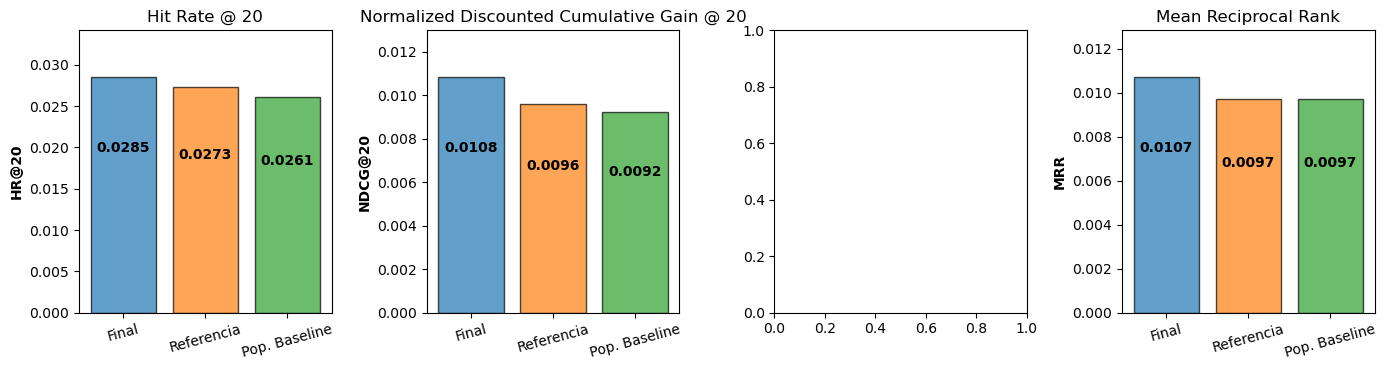

Plots saved to ../results/model_comparison_plots.png


In [12]:
import matplotlib.pyplot as plt
# Create bar plots for metrics comparison
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
#fig.suptitle('Comparación de modelos', fontsize=16, fontweight='bold')

# Define colors for models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
model_names = list(models_data.keys())


def add_internal_labels(ax, values):
    for i, v in enumerate(values):
        y_pos = v * 0.7 if v > 0 else 0.02
        ax.text(
            i,
            y_pos,
            f'{v:.4f}',
            ha='center',
            va='center',
            color='black',
            fontweight='bold'
        )


# # Plot 1: HR@5
# ax = axes[0]
# values = [models_data[m].get('HR@5', 0) for m in model_names]
# ax.bar(model_names, values, color=colors, alpha=0.7, edgecolor='black')
# ax.set_ylabel('HR@5', fontweight='bold')
# ax.set_title('Hit Rate @ 5')
# ax.set_ylim(0, max(values) * 1.2)
# add_internal_labels(ax, values)
# ax.tick_params(axis='x', rotation=15)

# # Plot 2: HR@10
# ax = axes[1]
# values = [models_data[m].get('HR@10', 0) for m in model_names]
# ax.bar(model_names, values, color=colors, alpha=0.7, edgecolor='black')
# ax.set_ylabel('HR@10', fontweight='bold')
# ax.set_title('Hit Rate @ 10')
# ax.set_ylim(0, max(values) * 1.2)
# add_internal_labels(ax, values)
# ax.tick_params(axis='x', rotation=15)

# Plot 3: HR@20
ax = axes[0]
values = [models_data[m].get('HR@20', 0) for m in model_names]
ax.bar(model_names, values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('HR@20', fontweight='bold')
ax.set_title('Hit Rate @ 20')
ax.set_ylim(0, max(values) * 1.2)
add_internal_labels(ax, values)
ax.tick_params(axis='x', rotation=15)


# Plot 3: NDCG@20
ax = axes[1]
values = [models_data[m].get('NDCG@20', 0) for m in model_names]
ax.bar(model_names, values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('NDCG@20', fontweight='bold')
ax.set_title('Normalized Discounted Cumulative Gain @ 20')
ax.set_ylim(0, max(values) * 1.2)
add_internal_labels(ax, values)
ax.tick_params(axis='x', rotation=15)



# Plot 4: MRR
ax = axes[3]
values = [models_data[m].get('MRR', 0) for m in model_names]
ax.bar(model_names, values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('MRR', fontweight='bold')
ax.set_title('Mean Reciprocal Rank')
ax.set_ylim(0, max(values) * 1.2)
add_internal_labels(ax, values)
ax.tick_params(axis='x', rotation=15)

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('../results/model_comparison_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plots saved to ../results/model_comparison_plots.png")
